In [2]:
import os
import umap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from combat.pycombat import pycombat
from sklearn.preprocessing import RobustScaler

/usr/local/anaconda3/envs/ibd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATA_DIR = '../../db'

In [34]:
db = pd.DataFrame()
dataset_label = pd.Series()
for filename in os.listdir(DATA_DIR):
    if not filename.endswith('.parquet') or filename.endswith('_metadata.parquet'):
        continue

    # read csv
    df = pd.read_parquet(os.path.join(DATA_DIR, filename))

    # append to dfs
    db = pd.concat([db, df])
    tmp = pd.Series([filename[:-8]] * len(df), index=df.index, name='dataset')
    dataset_label = pd.concat([dataset_label, tmp])

db = db.dropna(axis=1)

In [63]:
dup = db[db.duplicated(keep=False)]
dup.sort_values(by=['1'])

In [8]:
metadata = pd.read_parquet(os.path.join(DATA_DIR, 'GSE36807_metadata.parquet'))
metadata.head(20)

,patient_id,disease,treatment,response,time_of_biopsy
index,,,,,
GSM901319,08SE1903,Ctrl,None,None,None
GSM901320,08SE1904,Ctrl,None,None,None
GSM901321,08SE1905,Ctrl,None,None,None
GSM901322,08SE1906,Ctrl,None,None,None
GSM901323,08SE1907,Ctrl,None,None,None
GSM901324,08SE1910,Ctrl,None,None,None
GSM901325,08SE1911,Ctrl,None,None,None
GSM901326,08SE1892,CD,None,None,None
GSM901327,08SE1893,CD,None,None,None


/usr/local/anaconda3/envs/ibd/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


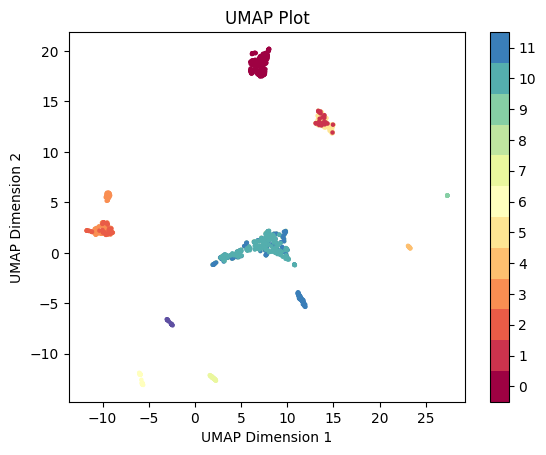

In [5]:
# Create UMAP embedding
umap_embedding = umap.UMAP().fit_transform(db)

# Plot UMAP embedding
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=pd.Categorical(dataset_label).codes, cmap='Spectral', s=5)
plt.title('UMAP Plot')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(boundaries=np.arange(13)-0.5).set_ticks(np.arange(12))
plt.show()

In [8]:
batch = pd.Categorical(dataset_label).codes

data_corrected = pycombat(db.transpose(), batch).transpose()

Found 13 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


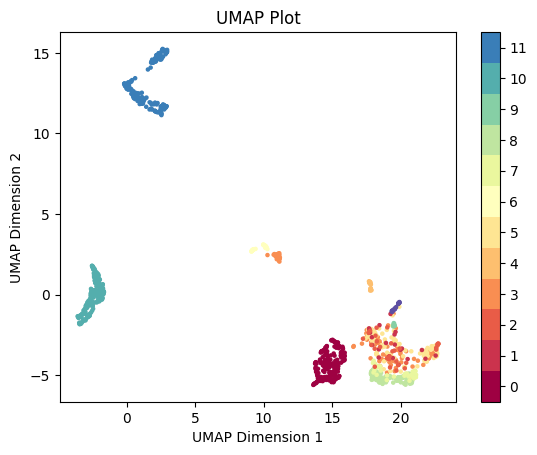

In [9]:
# Create UMAP embedding
umap_embedding = umap.UMAP().fit_transform(data_corrected)

# Plot UMAP embedding
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=pd.Categorical(dataset_label).codes, cmap='Spectral', s=5)
plt.title('UMAP Plot')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(boundaries=np.arange(13)-0.5).set_ticks(np.arange(12))
plt.show()

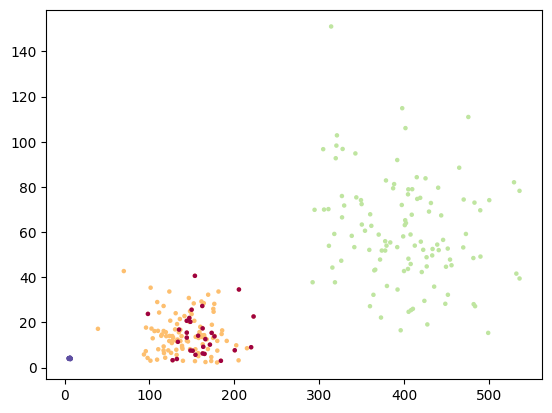

In [30]:
selected_sample_idxs = [d in ['GSE23597', 'GSE16879', 'GSE52746', 'GSE14580'] for d in dataset_label]
plot_data = db[selected_sample_idxs]

plt.scatter(plot_data.iloc[:, 5], plot_data.iloc[:, 6], c=pd.Categorical(dataset_label[selected_sample_idxs]).codes, cmap='Spectral', s=5)
plt.show()

In [45]:
# Function to normalize datasets individually
def robust_zscore_normalization_per_dataset(df, labels=None):
    if labels is None:
        labels = pd.Series([0] * len(df), index=df.index)

    # Initialize a DataFrame to hold the normalized data
    df_normalized = pd.DataFrame(index=df.index, columns=df.columns)

    # Loop over each unique dataset label and apply RobustScaler individually
    for dataset in labels.unique():
        # Filter the data for the current dataset
        dataset_mask = labels == dataset
        data_subset = df[dataset_mask]

        # Initialize RobustScaler object and fit to the current dataset
        scaler = RobustScaler()
        scaled_subset = scaler.fit_transform(data_subset)

        # Assign the normalized data back to the respective positions in the normalized DataFrame
        df_normalized.loc[dataset_mask] = scaled_subset

    return df_normalized

def quantile_normalization(df):
    # Rank the values within each column (gene), then average the rank scores for each row across all samples
    rank_mean = df.stack().groupby(df.rank(method='average').stack().astype(int)).mean()
    # Assign these averaged rank scores back based on the rank within each gene
    df_normalized = df.rank(method='average').stack().astype(int).map(rank_mean).unstack()
    
    # Ensuring the dataframe maintains the original index and column order
    df_normalized.index = df.index
    df_normalized.columns = df.columns
    
    return df_normalized

In [43]:
selected_sample_idxs = [d in ['GSE23597', 'GSE16879', 'GSE52746', 'GSE14580'] for d in dataset_label]
plot_data = db[selected_sample_idxs]

# normalize each dataset separately using standard normalization
for dataset in pd.Categorical(dataset_label[selected_sample_idxs]).categories:
    idxs = dataset_label[selected_sample_idxs] == dataset
    plot_data.loc[idxs] = (plot_data.loc[idxs] - plot_data.loc[idxs].mean()) / plot_data.loc[idxs].std()

/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_3519/2227639787.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[idxs] = (plot_data.loc[idxs] - plot_data.loc[idxs].mean()) / plot_data.loc[idxs].std()
/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_3519/2227639787.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.loc[idxs] = (plot_data.loc[idxs] - plot_data.loc[idxs].mean()) / plot_data.loc[idxs].std()
/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_3519/2227639787.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [46]:
db_robust_zscore_normalized = robust_zscore_normalization_per_dataset(db, dataset_label)

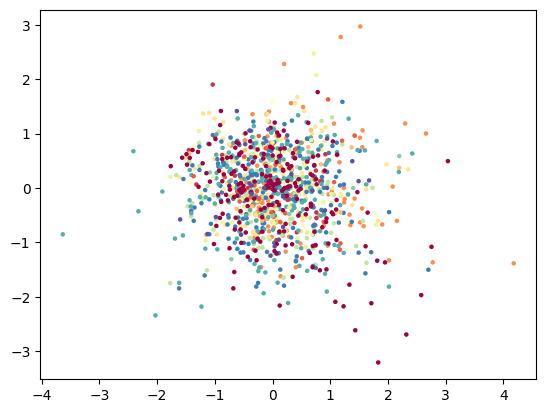

In [52]:
plt.scatter(db_robust_zscore_normalized.iloc[:, 10], db_robust_zscore_normalized.iloc[:, 11], c=pd.Categorical(dataset_label).codes, cmap='Spectral', s=5)
plt.show()

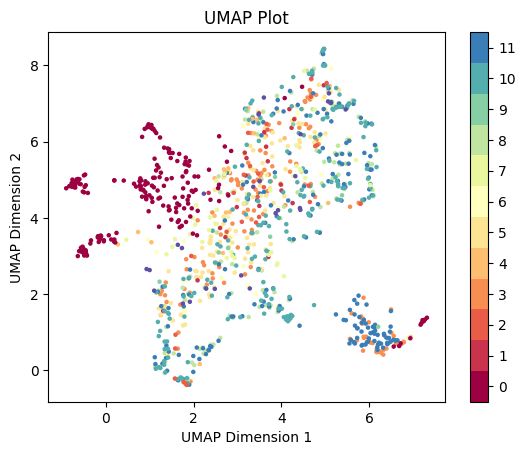

In [53]:
# Create UMAP embedding
umap_embedding = umap.UMAP().fit_transform(db_robust_zscore_normalized)

# Plot UMAP embedding
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=pd.Categorical(dataset_label).codes, cmap='Spectral', s=5)
plt.title('UMAP Plot')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(boundaries=np.arange(13)-0.5).set_ticks(np.arange(12))
plt.show()